In [1]:
import numpy as np
import os
import pandas as pd
import qml
import sys
sys.path.insert(0, '/home/misa/git_repositories/APDFT/prototyping/atomic_energies/')
import qml_interface as qmi
import scipy as sc
import itertools as it

from matplotlib import pyplot as plt

In [2]:
# labels
paths = qmi.wrapper_alch_data()
data, molecule_size = qmi.load_alchemy_data(qmi.wrapper_alch_data())

atomisation_en = qmi.generate_label_vector(data, molecule_size.sum(), value='atomisation')
atomic_en = qmi.generate_label_vector(data, molecule_size.sum(), value='atomic')
alch_pot = qmi.generate_label_vector(data, molecule_size.sum(), value='alch_pot')
charges = qmi.generate_label_vector(data, molecule_size.sum(), value='charge')

In [3]:
C = []
N = []
O = []
F = []
mixed = []
for i, d in enumerate(data):
    if not 7 in d[:,0] and not 8 in d[:,0] and not 9 in d[:,0]:
        C.append(paths[i])
    elif 7 in d[:,0] and not 8 in d[:,0] and not 9 in d[:,0]:
        N.append(paths[i])
    elif 8 in d[:,0] and not 7 in d[:,0] and not 9 in d[:,0]:
        O.append(paths[i])
    elif 9 in d[:,0] and not 7 in d[:,0] and not 8 in d[:,0]:
        F.append(paths[i])
    else:
        mixed.append(paths[i])

In [4]:
F

[]

In [5]:
# split elementwise
def split_elementwise(data_group, molecule_sizes_group, prop_name):
    """
    split property specified in propname elementwise for data defined in data_group, molecule_sizes_group is the length of the molecules in data_group
    """
    charges_group = qmi.generate_label_vector(data_group, molecule_sizes_group.sum(), value='charge')
    prop = qmi.generate_label_vector(data_group, molecule_sizes_group.sum(), value=prop_name)
    idc_by_charge = qmi.partition_idx_by_charge(charges_group)
    prop_dict = {k: [] for k in idc_by_charge.keys()}
    for k in prop_dict.keys():
        prop_dict[k] = prop[idc_by_charge[k]]
    return(prop_dict)


In [6]:
# load the data for every group
paths_groups = {'C':C, 'N':N, 'O':O, 'mixed':mixed}
groups = {'C':None, 'N':None, 'O':None, 'mixed':None}

for k in paths_groups.keys():
    groups[k] = qmi.load_alchemy_data(paths_groups[k])

In [7]:
# get property distribution split by element for every group
prop_name = 'atomic'
props = {'C':None, 'N':None, 'O':None, 'mixed':None}
for k in groups.keys():
    props[k] = split_elementwise(groups[k][0], groups[k][1], prop_name)


In [8]:
# plot distribution histograms for different groups but always for carbon
# histograms
bins = 'fd'

# split by element
hist_carbon = {'C':None, 'N':None, 'O':None, 'mixed':None}

for k in props.keys():
    hist_carbon[k] = np.histogram(props[k][6.0], bins=bins, range=(np.amin(props[k][6.0]), np.amax(props[k][6.0])))


In [9]:
hist_carbon['C'][0]

array([10, 30, 56, 45, 71, 53, 39, 37, 12,  6, 18, 12,  2,  4])

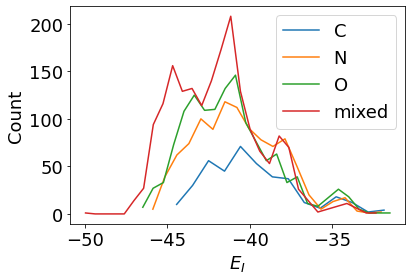

In [10]:
plt.rcParams['font.size'] = 18
fig, ax = plt.subplots(1,1)
for k in hist_carbon.keys():
    ax.plot(hist_carbon[k][1][:-1], hist_carbon[k][0], label = k)
ax.set_xlabel(r'$E_I$')
ax.set_ylabel(r'Count')
ax.legend()

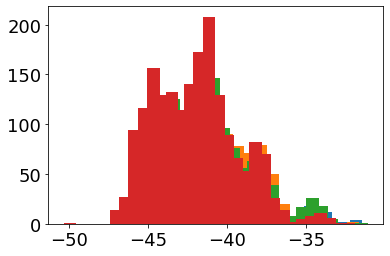

In [11]:
fig, ax = plt.subplots(1,1)
for k in hist_carbon.keys():
    plt.bar(hist_carbon[k][1][:-1], hist_carbon[k][0], label = k)
#ax.legend()

<BarContainer object of 14 artists>

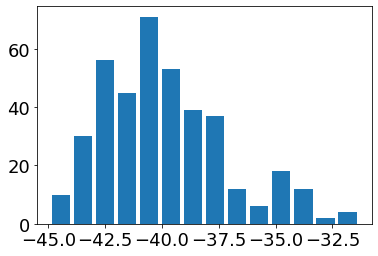

In [12]:
plt.bar(hist_carbon['C'][1][:-1], hist_carbon['C'][0], label = k)

<BarContainer object of 20 artists>

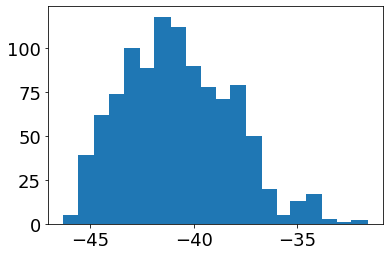

In [13]:
plt.bar(hist_carbon['N'][1][:-1], hist_carbon['N'][0], label = k)

<BarContainer object of 25 artists>

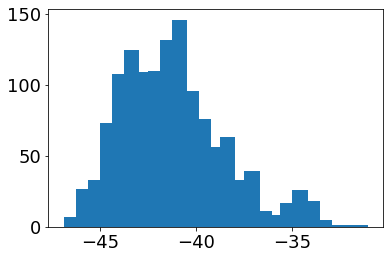

In [14]:
plt.bar(hist_carbon['O'][1][:-1], hist_carbon['O'][0], label = k)

<BarContainer object of 31 artists>

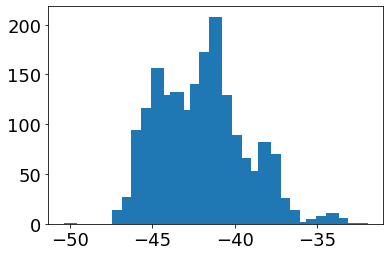

In [15]:
plt.bar(hist_carbon['mixed'][1][:-1], hist_carbon['mixed'][0], label = k)

### Number of H atoms per carbon
Is the order of atoms in the SMILES the same as in the .xyz-file/my data-files?
I iterated over the mols object and the order of atoms (without hydrogen) in the mol object from the smiles string in the qm9 data is the same as the order of atoms in the xyz-coordinates file for three molecules (dsgdb9nsd_001212, dsgdb9nsd_003664, dsgdb9nsd_003700)

In [16]:
from rdkit import Chem
from IPython.display import SVG
#from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
import sys
sys.path.insert(0, '/home/misa/git_repositories/APDFT/prototyping/atomic_energies/')
from explore_qml_data import get_smiles

def moltosvg(mol, molSize = (300,300), kekulize = True):
    mc = Chem.Mol(mol.ToBinary())
    if kekulize:
        try:
            Chem.Kekulize(mc)
        except:
            mc = Chem.Mol(mol.ToBinary())
    if not mc.GetNumConformers():
        rdDepictor.Compute2DCoords(mc)
    drawer = rdMolDraw2D.MolDraw2DSVG(molSize[0],molSize[1])
    drawer.DrawMolecule(mc)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    return svg.replace('svg:','')

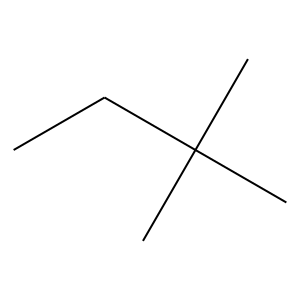

In [17]:
name = 'dsgdb9nsd_000228'
mol_003664 = Chem.MolFromSmiles(get_smiles(f'/home/misa/datasets/qm9/{name}.xyz'))
SVG(moltosvg(mol_003664))

In [18]:
for atom in mol_003664.GetAtoms():
    print(atom.GetAtomicNum(), atom.GetTotalNumHs(), atom.GetTotalDegree())

6 3 4
6 2 4
6 0 4
6 3 4
6 3 4
6 3 4


In [19]:
mol_data = qmi.load_alchemy_data([f'/home/misa/APDFT/prototyping/atomic_energies/results/slice_ve38/{name}/atomic_energies_with_mic.txt'])[0][0]

In [20]:
mol_data[:,0]

array([6., 6., 6., 6., 6., 6., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1.])

In [21]:
distO1 = []
distO2 = []

for i in range(len(mol_data)):
    distO1.append(np.linalg.norm(mol_data[2][1:4]-mol_data[i][1:4]))
    distO2.append(np.linalg.norm(mol_data[3][1:4]-mol_data[i][1:4]))

In [22]:
distO1

[4.96463995491395,
 2.928999358003685,
 0.0,
 2.9099130900207304,
 2.9110821510349054,
 2.9099131873530166,
 6.717096458961192,
 5.528030264503624,
 5.5281774205494685,
 4.08088373320461,
 4.080931310344001,
 4.136360091469914,
 4.125353275445269,
 4.150646111929804,
 4.13805619448963,
 4.1362878806653445,
 4.138056108189571,
 4.150653801630893,
 4.125341829426139,
 4.136366586335402]

In [23]:
distO2

[5.921518365223397,
 4.8076606814666105,
 2.9099130900207304,
 0.0,
 4.7340867356418395,
 4.753442066581752,
 7.773215611432953,
 5.391805074569925,
 6.704574619960985,
 5.243271269720839,
 6.5748525516304905,
 2.071111346448326,
 2.070323674392246,
 2.067911889166461,
 6.565237392627625,
 5.203287834744202,
 5.215989522241105,
 5.225855249613693,
 5.24511882670784,
 6.579023261811286]

In [24]:
no_heteros = pd.DataFrame(props['C'][6.0], columns = ['E_I'])

### make mol objs

In [25]:
mol_objs = []
for c in paths_groups['C']:
    smiles_path = os.path.join('/home/misa/datasets/qm9/', c.split('/')[-2]+'.xyz')
    mol_objs.append(Chem.MolFromSmiles(get_smiles(smiles_path)))

### get number of H-partners

In [26]:
num_H = []
for mol in mol_objs:
    for atom in mol.GetAtoms():
        num_H.append(atom.GetTotalNumHs())

In [27]:
no_heteros['num_H'] = num_H

### get number of bonding partners

In [28]:
degree = []
for mol in mol_objs:
    for atom in mol.GetAtoms():
        degree.append(atom.GetTotalDegree())

In [29]:
no_heteros['degree'] = degree

### get average nuclear charge of neighbors

In [30]:
charge_neighbours = []
chN = []
chH = []
for mol in mol_objs:
    for atom in mol.GetAtoms():
        degree = atom.GetTotalDegree() # number of binding partners
        neighbors = atom.GetNeighbors()
        charges_neighbors = 0
        for n in neighbors:
            charges_neighbors += n.GetAtomicNum()
        chN.append(charges_neighbors)
        charge_H = degree - len(neighbors) # number of hydrogens bonded that are not explicit; is equal to charge of implicit hydrogens
        chH.append(charge_H)
        charge = (charges_neighbors + charge_H)
        charge_neighbours.append(charge)

In [31]:
no_heteros['charge_neighbors'] = charge_neighbours

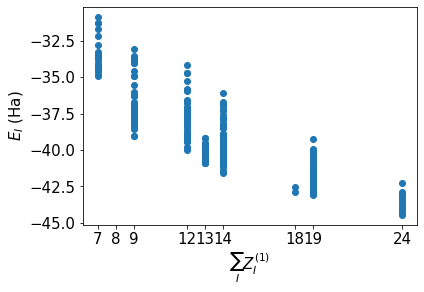

In [32]:
plt.rcParams['font.size'] = 15
fig, ax = plt.subplots(1,1)
ax.plot(no_heteros['charge_neighbors'], no_heteros['E_I'], 'o')
ax.set_xlabel('$\sum_I Z_I^{(1)}$')
ax.set_ylabel('$E_I$ (Ha)')
ax.set_xticks([7,8,9,12,13,14, 18, 19, 24])

In [33]:
# summarize data

In [34]:
deg4 = no_heteros.loc[no_heteros['degree'] == 4, ['E_I']]
deg3 = no_heteros.loc[no_heteros['degree'] == 3, ['E_I']]
deg2 = no_heteros.loc[no_heteros['degree'] == 2, ['E_I']]
deg1 = no_heteros.loc[no_heteros['degree'] == 1, ['E_I']]
deg_type = [deg1, deg2, deg3, deg4]

In [35]:
deg_hist = []
for d in deg_type:
    deg_hist.append(np.histogram(d))

In [36]:
deg2_hist = np.histogram(deg2)
deg3_hist = np.histogram(deg3)
deg4_hist = np.histogram(deg4)

<BarContainer object of 10 artists>

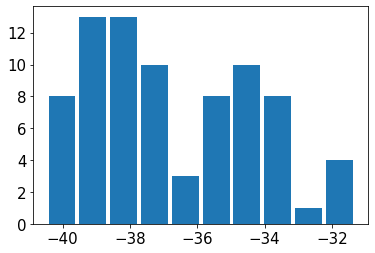

In [37]:
plt.bar(deg2_hist[1][:-1], deg2_hist[0])

<BarContainer object of 10 artists>

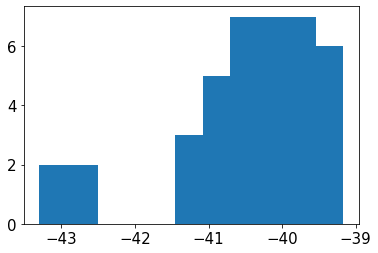

In [38]:
plt.bar(deg3_hist[1][:-1], deg3_hist[0])

<BarContainer object of 10 artists>

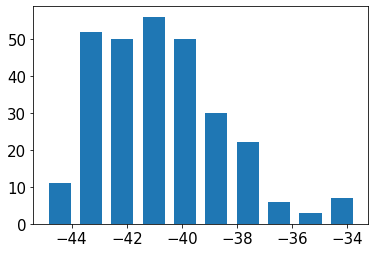

In [39]:
plt.bar(deg4_hist[1][:-1], deg4_hist[0])

In [40]:
# split by number of H-partners

In [41]:
prim = no_heteros['num_H'] == 3
sec = no_heteros['num_H'] == 2
tert = no_heteros['num_H'] == 1
quart = no_heteros['num_H'] == 0

c_type = [prim, sec, tert, quart]

In [42]:
no_heteros.loc[prim, ['E_I']].mean()
no_heteros.loc[sec, ['E_I']].mean()
no_heteros.loc[tert, ['E_I']].mean()
no_heteros.loc[quart, ['E_I']].mean()

E_I   -39.23826
dtype: float64

In [43]:
hist = []
for t in c_type:
    hist.append(np.histogram(no_heteros.loc[t, ['E_I']]))

<BarContainer object of 10 artists>

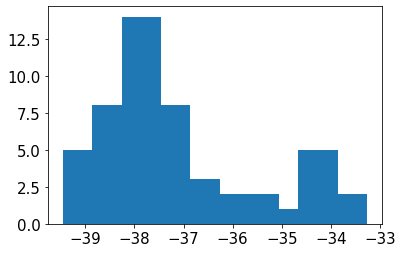

In [44]:
plt.bar(hist[0][1][:-1], hist[0][0], label = 'prim')

<BarContainer object of 10 artists>

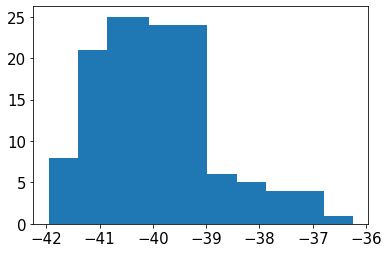

In [45]:
plt.bar(hist[1][1][:-1], hist[1][0], label = 'prim')

<BarContainer object of 10 artists>

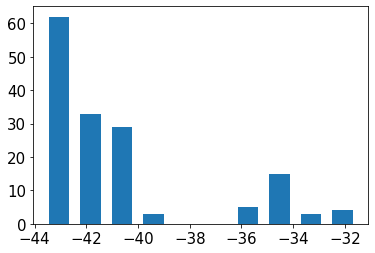

In [46]:
plt.bar(hist[2][1][:-1], hist[2][0], label = 'prim')

<BarContainer object of 10 artists>

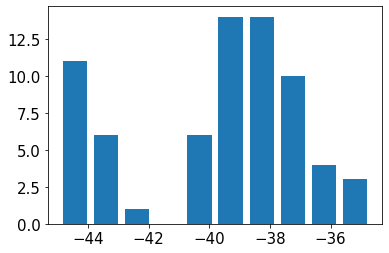

In [47]:
plt.bar(hist[3][1][:-1], hist[3][0], label = 'prim')

In [48]:
# split quart, tert by number of bonding partners

In [49]:
terts = no_heteros.loc[tert]
quarts = no_heteros.loc[quart]
terts_saturated = terts.loc[terts['degree']>2]
terts_saturated_hist = np.histogram(terts_saturated['E_I'])
terts_unsaturated = terts.loc[terts['degree']<3]
terts_unsaturated_hist = np.histogram(terts_unsaturated['E_I'])

<BarContainer object of 10 artists>

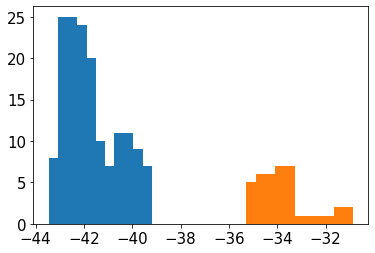

In [50]:
plt.bar(terts_saturated_hist[1][:-1], terts_saturated_hist[0])
plt.bar(terts_unsaturated_hist[1][:-1], terts_unsaturated_hist[0])

<BarContainer object of 10 artists>

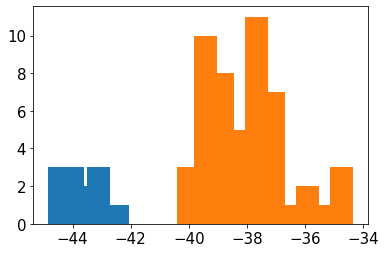

In [51]:
quarts = no_heteros.loc[quart]
quarts_saturated = quarts.loc[quarts['degree']>2]
quarts_saturated_hist = np.histogram(quarts_saturated['E_I'])
quarts_unsaturated = quarts.loc[quarts['degree']<3]
quarts_unsaturated_hist = np.histogram(quarts_unsaturated['E_I'])

plt.bar(quarts_saturated_hist[1][:-1], quarts_saturated_hist[0])
plt.bar(quarts_unsaturated_hist[1][:-1], quarts_unsaturated_hist[0])

### split data by binding partner and number of H atoms

In [52]:
subset = []

for degree in range(2, 5):
    for num_H in range(0, degree):
        print(degree, num_H)
        subset_tmp = no_heteros.loc[(no_heteros['degree'] == degree) & (no_heteros['num_H'] == num_H), ['E_I']]
        subset.append(subset_tmp)

2 0
2 1
3 0
3 1
3 2
4 0
4 1
4 2
4 3


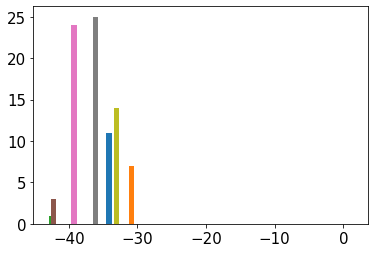

In [53]:
hist_bp_nH = []
for s in subset:
    hist_tmp = np.histogram(s)
    hist_bp_nH.append(hist_tmp)
    plt.bar(hist_tmp[1][-1], hist_tmp[0])

In [54]:
hist_bp_nH[0]

(array([ 3, 10,  8,  5, 11,  7,  1,  2,  1,  3]),
 array([-40.01432111, -39.42943715, -38.84455319, -38.25966922,
        -37.67478526, -37.0899013 , -36.50501734, -35.92013337,
        -35.33524941, -34.75036545, -34.16548149]))

<BarContainer object of 10 artists>

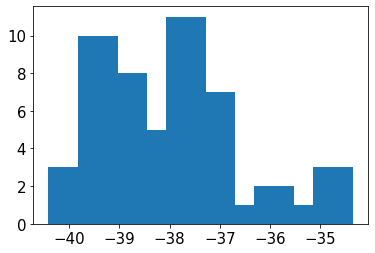

In [55]:
plt.bar(hist_bp_nH[0][1][:-1], hist_bp_nH[0][0])

<BarContainer object of 10 artists>

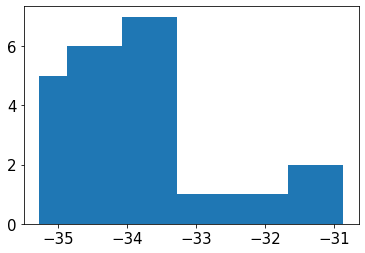

In [56]:
plt.bar(hist_bp_nH[1][1][:-1], hist_bp_nH[1][0])

<BarContainer object of 10 artists>

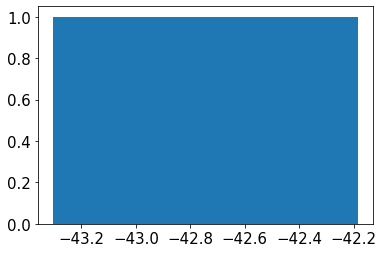

In [57]:
plt.bar(hist_bp_nH[2][1][:-1], hist_bp_nH[2][0])

<BarContainer object of 10 artists>

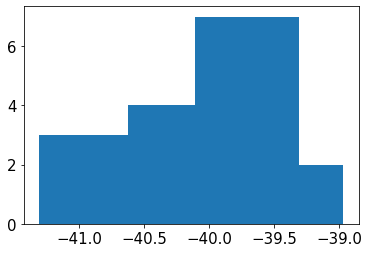

In [58]:
plt.bar(hist_bp_nH[3][1][:-1], hist_bp_nH[3][0])

<BarContainer object of 10 artists>

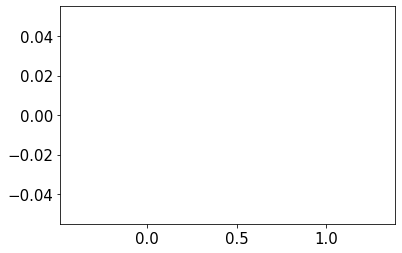

In [59]:
plt.bar(hist_bp_nH[4][1][:-1], hist_bp_nH[4][0])

<BarContainer object of 10 artists>

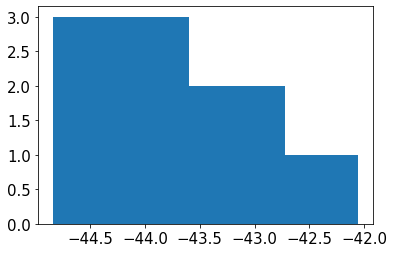

In [60]:
plt.bar(hist_bp_nH[5][1][:-1], hist_bp_nH[5][0])

<BarContainer object of 10 artists>

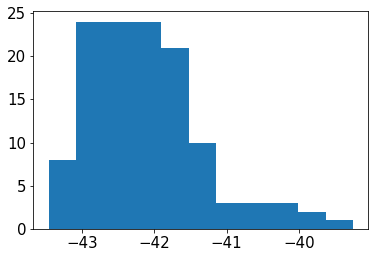

In [61]:
plt.bar(hist_bp_nH[6][1][:-1], hist_bp_nH[6][0])

<BarContainer object of 10 artists>

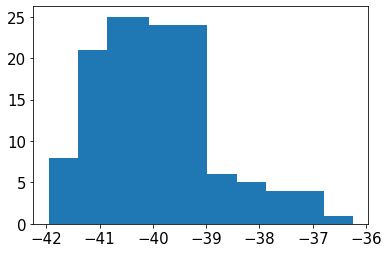

In [62]:
plt.bar(hist_bp_nH[7][1][:-1], hist_bp_nH[7][0])

<BarContainer object of 10 artists>

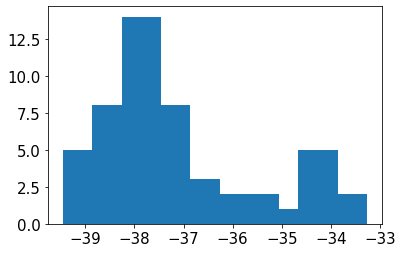

In [63]:
plt.bar(hist_bp_nH[8][1][:-1], hist_bp_nH[8][0])

In [64]:
# labels
paths = qmi.wrapper_alch_data()
data, molecule_size = qmi.load_alchemy_data(qmi.wrapper_alch_data())

atomisation_en = qmi.generate_label_vector(data, molecule_size.sum(), value='atomisation')
atomic_en = qmi.generate_label_vector(data, molecule_size.sum(), value='atomic')
alch_pot = qmi.generate_label_vector(data, molecule_size.sum(), value='alch_pot')
charges = qmi.generate_label_vector(data, molecule_size.sum(), value='charge')

In [65]:
atomic_dict = split_elementwise(data, molecule_size, 'atomic')

In [66]:
# make mol objects for all molecules
mol_objs = []
for c in paths:
    smiles_path = os.path.join('/home/misa/datasets/qm9/', c.split('/')[-2]+'.xyz')
    mol_objs.append(Chem.MolFromSmiles(get_smiles(smiles_path)))

In [67]:
# get charge in first coordination sphere
charge_neighbours = []
chN = []
chH = []
for mol in mol_objs:
    for atom in mol.GetAtoms():
        if atom.GetAtomicNum() == 6:
            degree = atom.GetTotalDegree() # number of binding partners
            neighbors = atom.GetNeighbors()
            charges_neighbors = 0
            for n in neighbors:
                charges_neighbors += n.GetAtomicNum()
            chN.append(charges_neighbors)
            charge_H = degree - len(neighbors) # number of hydrogens bonded that are not explicit; is equal to charge of implicit hydrogens
            chH.append(charge_H)
            charge = (charges_neighbors + charge_H)
            charge_neighbours.append(charge)

In [68]:
len(atomic_dict[6.0])

4611

In [69]:
len(np.array(charge_neighbours).T)

4611

In [70]:
np.array([atomic_dict[6.0], np.array(charge_neighbours)]).T.shape

(4611, 2)

In [71]:
all_composition = pd.DataFrame(data = np.array([atomic_dict[6.0], np.array(charge_neighbours)]).T, columns = ['E_I', 'chN'])

In [72]:
subsets = []
chN = []
for s in set(all_composition['chN']):
    subset_tmp = all_composition.loc[all_composition['chN']==s, ['E_I']]
    chN.append(s)
    subsets.append(subset_tmp)

Text(0, 0.5, '$E_I$ (Ha)')

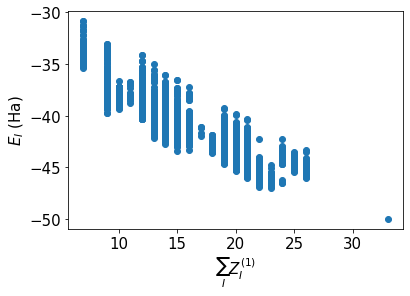

In [77]:
fig, ax = plt.subplots(1,1)
ax.plot(all_composition['chN'], all_composition['E_I'], 'o')

ax.set_xlabel('$\sum_I Z_I^{(1)}$')
ax.set_ylabel('$E_I$ (Ha)')
#ax.set_xticks([7,8,9,12,13,14, 18, 19, 24])
#ax.legend()